<a href="https://colab.research.google.com/github/mledwar8/marissa/blob/main/EdwardsMarissaMAE598Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[1] loss: 3.221


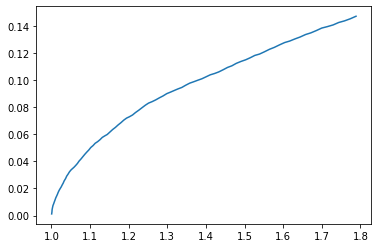

[2] loss: 3.133


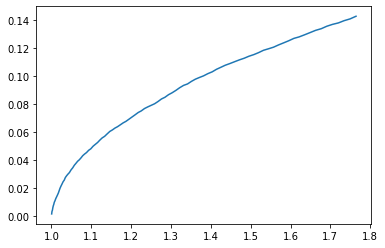

[3] loss: 3.119


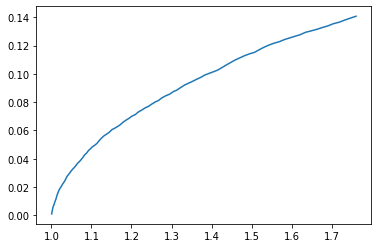

[4] loss: 3.165


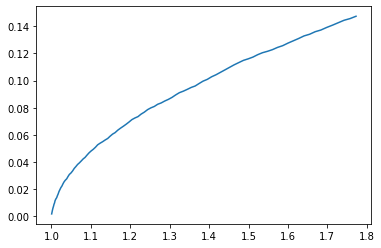

[5] loss: 3.303


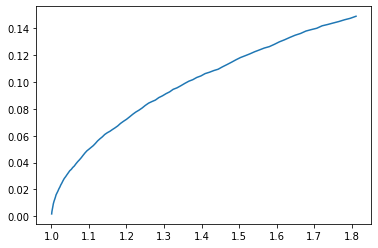

[6] loss: 3.124


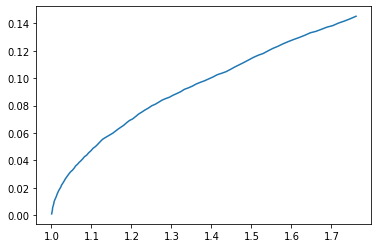

[7] loss: 3.203


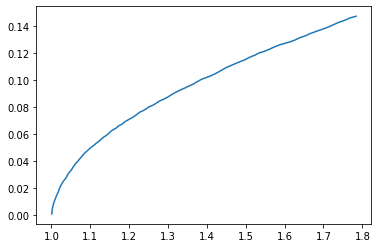

[8] loss: 3.212


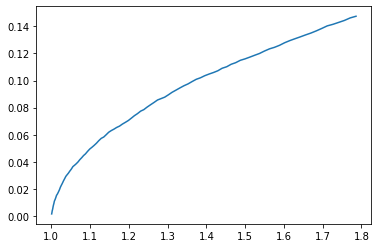

[9] loss: 3.265


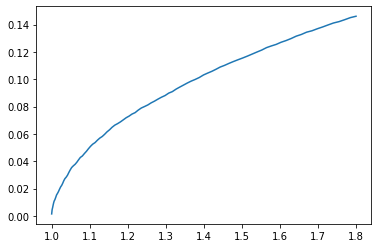

[10] loss: 3.059


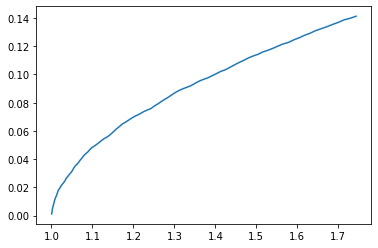

[11] loss: 3.158


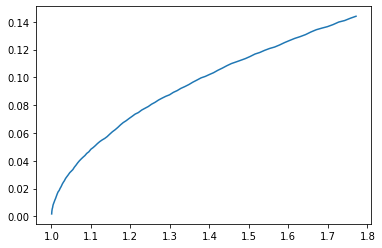

[12] loss: 3.095


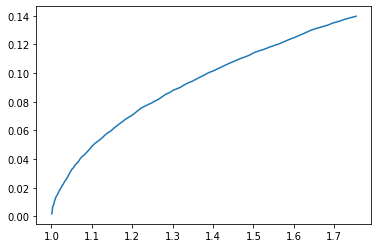

[13] loss: 3.295


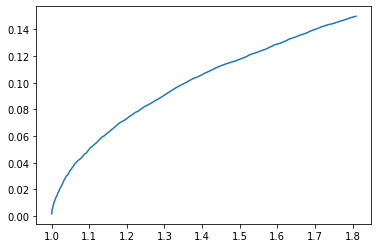

[14] loss: 3.212


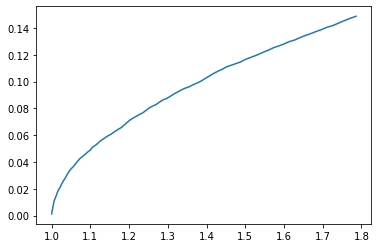

[15] loss: 3.070


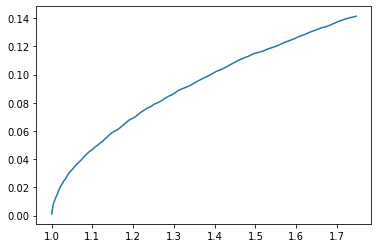

[16] loss: 3.133


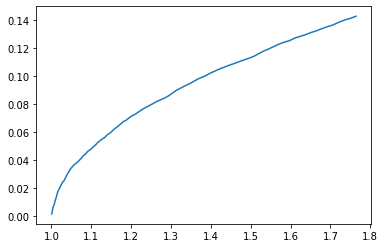

[17] loss: 3.172


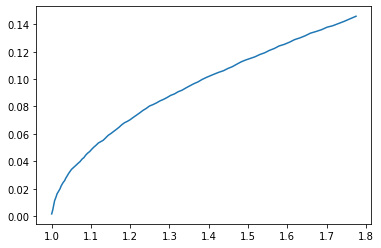

[18] loss: 3.137


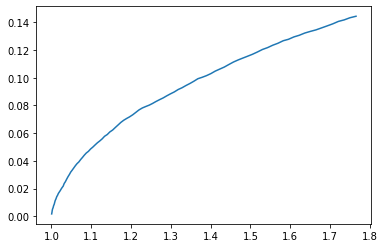

[19] loss: 3.067


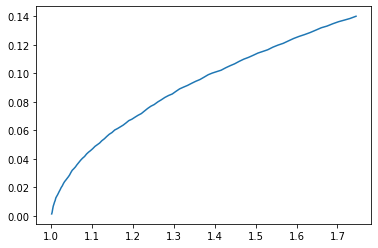

[20] loss: 3.145


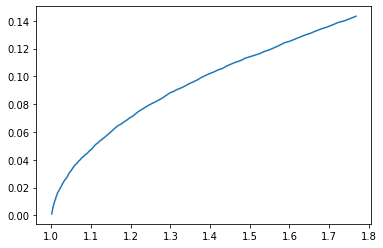

[21] loss: 3.146


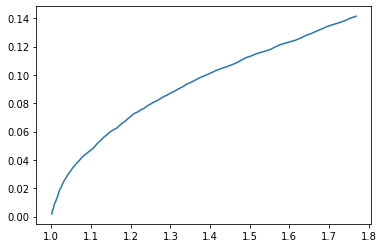

[22] loss: 3.205


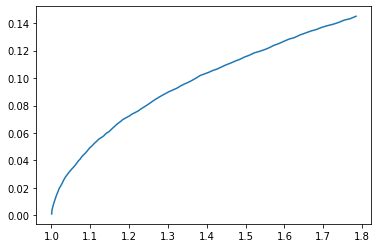

[23] loss: 3.202


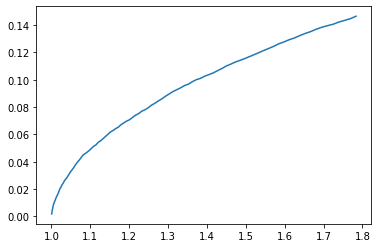

[24] loss: 3.154


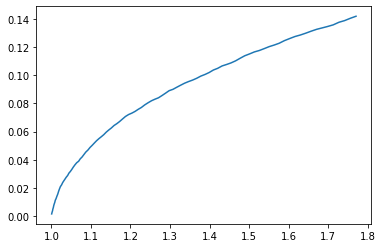

[25] loss: 3.188


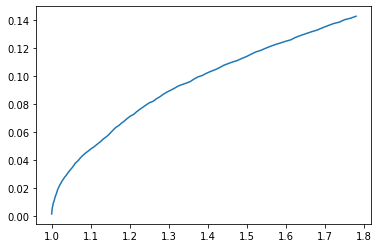

[26] loss: 3.087


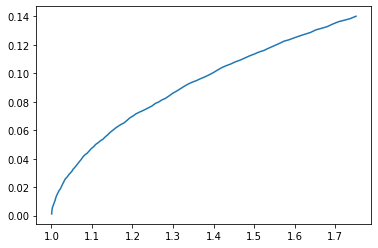

[27] loss: 3.213


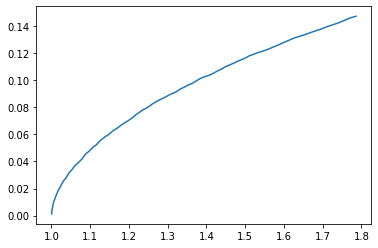

[28] loss: 3.133


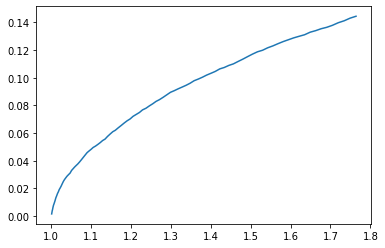

[29] loss: 3.154


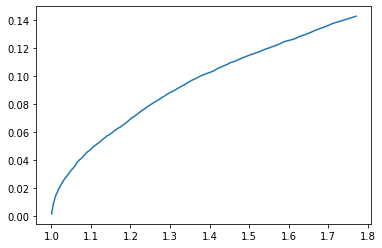

[30] loss: 3.134


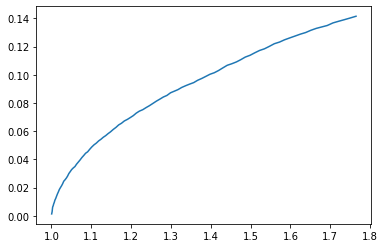

[31] loss: 3.162


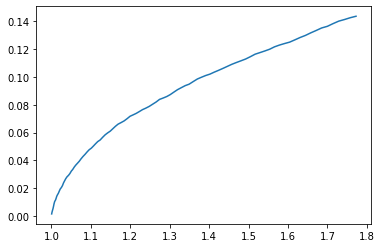

[32] loss: 3.233


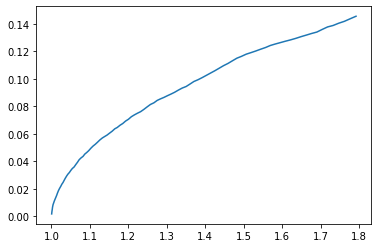

[33] loss: 3.163


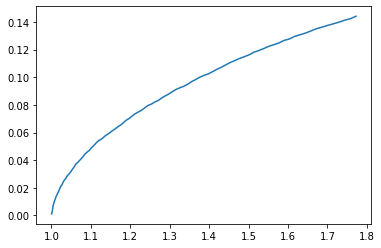

[34] loss: 3.257


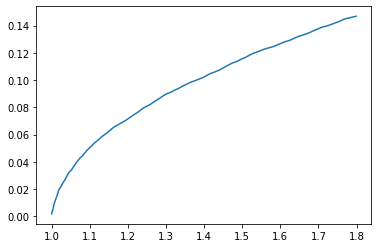

[35] loss: 3.205


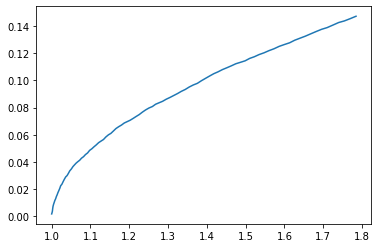

[36] loss: 3.169


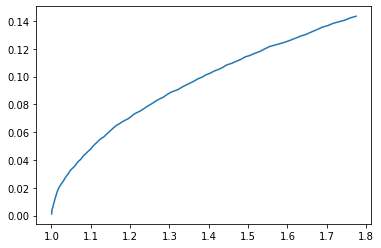

[37] loss: 3.180


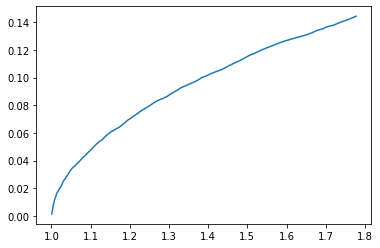

[38] loss: 3.050


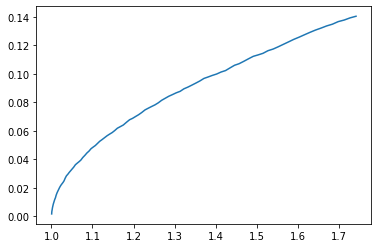

[39] loss: 3.074


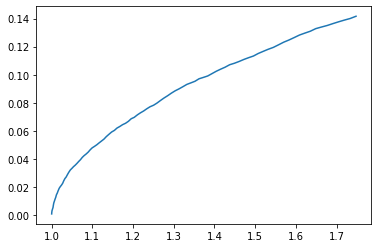

[40] loss: 3.130


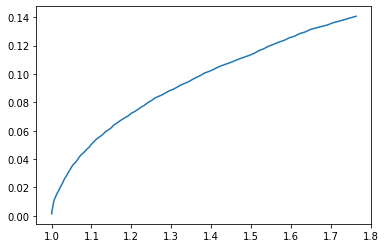

In [5]:
# Marissa Edwards Optimization Project 1
# Want rocket to land as optimized as possible

# This code is attempting 1 and 5 from the list (objectives)
# 1 - More realistic definition of state and action spaces: Rocket orientation, angular velocity, etc.
# 5 - Randomness in dynamics, sensing, etc.

# Overhead
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
# environment parameters

# Givens
FRAME_TIME = 0.1  # time interval 
GRAVITY_ACCEL = 9.81 / 1000  # gravity constant normalized (assume)
BOOST_ACCEL =  14.715 / 1000 # thrust constant normalized (assume)

# Givens depending on problem (for problem 1)
ROTATION_ACCEL = 20  # rotation constant
angular_velocity = ROTATION_ACCEL * FRAME_TIME

# Dynamics of Rocket
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        state[2] = theta
        """
        # ^ added state 2 for problem 1

        # Apply gravity 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])
        # tried to add angular velocity 
        # delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, angular_velocity])
        # to account for state two but when added to the code it does not run
        # the matrix operators did not work

        # State Matrix for problem 1
        statemat = t.tensor([[0., 0.], [0., 0.], [0., 0.]]) 
        # State matrix for 3 states by 2 actions
        # Empty matrix for matrix multiplication that fits 3 states
       
        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.rand([2]) * action 
        # added randomness in dynamics sensing for thrust (t.rand([2])) for #5

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME], [0., 1.]])
        # Tried to change step_mat to a 3x2 matrix to fit 3 states for problem 1
        # step_mat = t.tensor([[1., FRAME_TIME], [0., 1.],[1., angular_velocity]])
        # ^ Potential code that would be added but does not run
        state = t.matmul(step_mat, state)

        return state

# Controller
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

# Simulator
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2

# Optimizer
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        plt.plot(x, y)
        plt.show()
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 25  # latent dimensions (Changed to 25 to lower loss)
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem

# Results/Analysis

# Please document the convergence and the optimal solutions (e.g., the state trajectory if it is a control problem).

# Lower loss is ideal so when the loss was able to be optimized 
# The code was able to run [1] loss: 3.221 to [40] loss: 3.130
# Which was able to minimize the loss 

# Addionally after viewing the graphs as well, it does converge to the optimial solution
# (aka, the line become more flatter as the iterations go on)

